## Example 11 - Simulation Exercise

* [**0. Import required libraries:**](#0.-Import-required-libraries)<br>
* [**1. Create network elements:**](#1.-Create-network-elements)<br>
* [**2. Create graph from network elements:**](#2.-Create-graph-from-network-elements)<br>
* [**3. Create vessel objects:**](#3.-Create-vessel-objects)<br>
* [**4. Run the simulation:**](#4.-Run-the-simulation)<br>
* [**5. Post processing:**](#5.-Post-processing)<br>

## 0. Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

## 1. Create network elements
You can specify network element objects by entering mix-ins:

    core.Berthable - enables handling of servicing process at a specific berth (lengthvessel, servicetime, quayobject)
    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.Locatable - enables you to add coordinates to extract distance information and visualize
    core.HasContainer - enables you to add information on the material available at the site
    core.HasResource - enables you to add information on serving equipment
    core.HasWeather - enables you to add weather conditions
    core.HasLength - enables waiting to be triggered when insufficient length is available (quaylength)
    core.HasTurningCircle - to define an object that has a turning circle, i.e. a turning basin (turntime)
    core.RequiresTurning - if turning is required in this node a timeout is given, at specific location (maketurnat)

#### First create objects with the desired properties

In [2]:
Node = type('Node', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
Quay = type('Quay', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.HasLength), {})
Turn = type('Turn', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.HasTurningCircle), {})

#### Next specify the properties for objects you wish to create

In [3]:
# anchorage
data_node_01 = {"env": [],
               "name": "anchorage",
               "geometry": shapely.geometry.Point(0, 0)}

# nodes
data_node_02 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(2, 0)}
data_node_03 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(4, 0)}
data_node_04 = {"env": [],
               "name": "Node 3",
               "geometry": shapely.geometry.Point(5, 0)}

# turning basins
# todo: implement the turning timeout
data_node_05 = {"env": [],
               "name": "tb5",
               "turntime": 300,
               "geometry": shapely.geometry.Point(9, 0)}
data_node_07 = {"env": [],
               "name": "tb7",
               "turntime": 300,
               "geometry": shapely.geometry.Point(12, 0)}
data_node_09 = {"env": [],
               "name": "tb9",
               "turntime": 300,
               "geometry": shapely.geometry.Point(15, 0)}

# berths
data_berth_52 = {"env": [],
               "name": "b52",
               "geometry": shapely.geometry.Point(9, -1),
               "quaylength": 300}
data_berth_62 = {"env": [],
               "name": "b62",
               "geometry": shapely.geometry.Point(12, -1),
               "quaylength": 300}
data_berth_72 = {"env": [],
               "name": "b72",
               "geometry": shapely.geometry.Point(15, 1),
               "quaylength": 300}

#### Finally create specific instances of the predefined objects with the specified properties

In [4]:
# anchorage
anchor = Node(**data_node_01)

# nodes
node_1 = Node(**data_node_02)
node_2 = Node(**data_node_03)
node_3 = Node(**data_node_04)

# turning basins
tb1    = Turn(**data_node_05)
tb2    = Turn(**data_node_07)
tb3    = Turn(**data_node_09)

# berths
berth1 = Quay(**data_berth_52)
berth2 = Quay(**data_berth_62)
berth3 = Quay(**data_berth_72)

In [5]:
type(berth1)

__main__.Quay

## 2. Create graph from network elements

#### Define nodes and edges from network element objects

In [6]:
nodes = [anchor, node_1, node_2, node_3, tb1, berth1, tb2, berth2, tb3, berth3]

edges = [[anchor, node_1], 
        [node_1, node_2], 
        [node_2, node_3], 
        [node_3, tb1], 
        [tb1, berth1],
        [berth1, tb1],
        [tb1, tb2],
        [tb2, berth2],
        [berth2, tb2],
        [tb2, tb3],
        [tb3, berth3],
        [berth3, tb3],
        [tb3, tb2],
        [tb2, tb1],
        [tb1, node_3], 
        [node_3, node_2],
        [node_2, node_1],
        [node_1, anchor]] 

#### Use nodes and edges to construct a graph

In [7]:
FG = nx.DiGraph()

labels = {}
for node in nodes:
    labels[node.name] = (node.geometry.x, node.geometry.y)
    if isinstance(node, Turn):
        FG.add_node(node.name, geometry = node.geometry, Object = node)
    elif isinstance(node, Quay):
        FG.add_node(node.name, geometry = node.geometry, Object = node)
    else:
        FG.add_node(node.name, geometry = node.geometry)

for edge in edges:
    if isinstance(edge[0], Quay):
        print("quay")
        FG.add_edge(edge[0].name, edge[1].name, Object = edge[0], weight = 1)
        print(edge)
    elif isinstance(edge[0], Turn):
        FG.add_edge(edge[0].name, edge[1].name, Object = "Turning Basin", weight = 1)
    else:
        FG.add_edge(edge[0].name, edge[1].name, weight = 1)

quay
[<__main__.Quay object at 0x000002A973E92828>, <__main__.Turn object at 0x000002A973E92940>]
quay
[<__main__.Quay object at 0x000002A973E92780>, <__main__.Turn object at 0x000002A973E92B70>]
quay
[<__main__.Quay object at 0x000002A973E92F98>, <__main__.Turn object at 0x000002A973E92A58>]


#### Draw graph

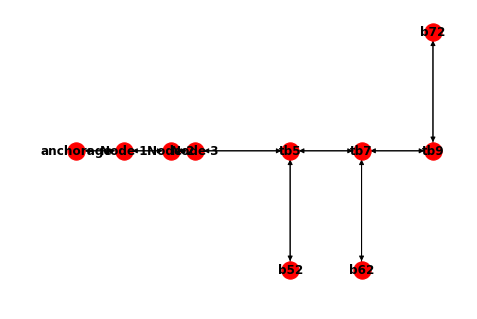

In [8]:
nx.draw(FG, labels, with_labels=True, font_weight='bold')

In [9]:
# To show that moving from Node 4 to Node 1 is not possible
print("From b52 to b62:", nx.shortest_path_length(FG, "b52", "b72"), "steps.")
print("From b62 to anchorage:", nx.shortest_path_length(FG, "b72", "anchorage"), "steps.")
# print("From 4 to 1:", nx.shortest_path_length(FG, "Node 4", "Node 1"))

From b52 to b62: 4 steps.
From b62 to anchorage: 7 steps.


## 3. Create vessel objects

#### First create objects with the desired properties

In [10]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable, core.Berthable, core.RequiresTurning), {})


#### Next specify the properties for objects you wish to create

In [11]:
# Each vessel needs a path in and out of the system
# todo: this may just be captured in a function with an entry point and a destination

# Vessel_1 moves first from "anchorage" to "b72" and then back to "anchorage"
path_1 = nx.dijkstra_path(FG, "anchorage", "b72")
path_2 = nx.dijkstra_path(FG, "b72", "anchorage")
path_vessel_1 = np.concatenate((path_1, path_2[1:]), axis = None)

# Vessel_2 moves first from "anchorage" to "b52" and then back to "anchorage"
path_1 = nx.dijkstra_path(FG, "anchorage", "b52")
path_2 = nx.dijkstra_path(FG, "b52", "anchorage")
path_vessel_2 = np.concatenate((path_1, path_2[1:]), axis = None)

path_1 = nx.dijkstra_path(FG, "anchorage", "b52")
path_2 = nx.dijkstra_path(FG, "b52", "b62")
path_3 = nx.dijkstra_path(FG, "b62", "anchorage")
path_vessel_3 = np.concatenate((path_1, path_2[1:], path_3[1:]), axis = None)

In [12]:
# Define lambda functions where needed

# For testing purposes we only want the vessels to sail with v = 1 m/s (distance in m = time travelled)
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

In [13]:
# todo: I think length quay should not be a vessel property. It should be read from the quay object when needed
data_vessel_1 = {"env": None,
               "name": "Vessel number 1",
               "route": path_vessel_1,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "servicetime": 18000,
               "quayobject": berth3,
               "lengthvessel": 100,
               "maketurnat": tb3,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

data_vessel_2 = {"env": None,
               "name": "Vessel number 2",
               "route": path_vessel_2,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "servicetime": 360000,
               "quayobject": berth1,
               "lengthvessel": 180,
               "maketurnat": tb1,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

data_vessel_3 = {"env": None,
               "name": "Vessel number 3",
               "route": path_vessel_3,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "servicetime": 18000,
               "quayobject": berth1,
               "lengthvessel": 80,
               "maketurnat": tb1,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

In [14]:
vessels = []
# create the transport resource
# vessels.append(TransportResource(**data_vessel_1))
vessels.append(TransportResource(**data_vessel_2))
vessels.append(TransportResource(**data_vessel_3))

## 4. Run the simulation

In [15]:
# process that each vessel fill follow
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        print("{} started sailing".format(vessel.name))
 
        yield from vessel.move()
    
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        print("{} stopped sailing".format(vessel.name))
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [16]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
for vessel in vessels:
    vessel.env = env

    # Start the simulation
    env.process(start(env, vessel))

# instantiate all processes and only execute env.run() once at the end
env.run()

Vessel number 2 started sailing
Vessel number 3 started sailing
Vessel number 2 makes turn in Turning Basin tb5  to approach quay b52
Vessel number 3 makes turn in Turning Basin tb5  to approach quay b52
t =  1553690634.8056972 Vessel number 2 arrived at quay b52 (service time is 360000 s), remaining quay length: 120 m
t =  1553690634.8056972 Vessel number 3 arrived at quay b52 (service time is 18000 s), remaining quay length: 40 m
t =  1553708634.8056972  Servicing done, quay space released (available quay length: 120 m)
Vessel number 3 left quay b52  and makes turn in Turning Basin tb5
t =  1554050634.8056972  Servicing done, quay space released (available quay length: 300 m)
Vessel number 2 left quay b52  and makes turn in Turning Basin tb5
t =  1554264042.055193 Vessel number 3 arrived at quay b62 (service time is 18000 s), remaining quay length: 220 m
t =  1554282042.055193  Servicing done, quay space released (available quay length: 300 m)
Vessel number 3 left quay b62  and makes

In [17]:
# todo: Add "call on service" -> check if enough space available at quay before sailing there

In [18]:
# todo: Add turning basin - with certain turntime - to the process

## 5. Post processing
Here postprocessing functions and graphs should be placed

In [19]:
vessels[0].route

array(['anchorage', 'Node 1', 'Node 2', 'Node 3', 'tb5', 'b52', 'tb5',
       'Node 3', 'Node 2', 'Node 1', 'anchorage'], dtype='<U9')

In [20]:
vessels[1].route

array(['anchorage', 'Node 1', 'Node 2', 'Node 3', 'tb5', 'b52', 'tb5',
       'tb7', 'b62', 'tb7', 'tb5', 'Node 3', 'Node 2', 'Node 1',
       'anchorage'], dtype='<U9')

In [21]:
vessels[1].name

'Vessel number 3'

In [22]:
print(FG.nodes["b72"])

{'geometry': <shapely.geometry.point.Point object at 0x000002A976BEE240>, 'Object': <__main__.Quay object at 0x000002A973E92F98>}
